In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import numpy as np
import allel
import itertools
import os
from subprocess import call
from tqdm import tqdm, trange
from scipy.stats import chi2_contingency

import statsmodels.api as sm
import statsmodels.formula.api as smf

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #allows multiple outputs

### Classification Functions

In [2]:
#AA caller, based on frequency.
def AA_caller(frequency, reference, alternative):
    if (frequency > 0.5):
        return alternative
    elif (frequency < 0.5):
        return reference
    else:
        return np.nan

In [3]:
#mutation direction classification
strong_bases= ['G', 'C']
weak_bases= ['A', 'T']

def strength_classifier(ancestor, derived):
    if (ancestor in strong_bases) and (derived in weak_bases):
        return 'SW'
    elif (ancestor in weak_bases) and (derived in strong_bases):
        return 'WS'
    else:
        return 'NN'

In [4]:
#Define frequency of the Derived State, the mutation
#if ALT = Derived, keep the original AF, which describes the frequency of the ALT
#if REF = Derived, use 1 - AF

def mutation_frequency (Derived, ALT, AF):
    if Derived == ALT: #this means derived is ALT, which AF is associated with
        return AF
    if Derived != ALT: #this means dervied is REF, which is inversely associated with AF
        return (1-AF)
    else:
        return 'Error'

In [5]:
#Ancestry based on allele frequency

def barcoder(strength, frequency):
    if (strength == 'SW') and (frequency <= 0.1):
        return 'SW-Rare'
    elif (strength == 'SW') and (0.25 <= frequency <= 0.5):
        return 'SW-Common'
    elif (strength == 'WS') and (frequency <= 0.1):
        return 'WS-Rare'
    elif (strength == 'WS') and (0.25 <= frequency <= 0.5):
        return 'WS-Common'
    else:
        return 'NaN'

### Polistes, INTERgenic

In [6]:
Pdom_Intergenic_raw = pd.read_table('/home/taeyoon/VcfFiles/Annotated/Polistes-intergenic.recode.vcf', header=None, comment='#')

Pdom_Intergenic_raw.rename(columns={0:"SCAF", 
    1:"POS", 2:"ID", 3:"REF", 4:"ALT", 5:"QUAL", 6:"FILTER", 7:"INFO", 8:"FORMAT", 
    9:"1", 10:"10", 11:"11", 12:"2b", 13:"3", 14:"4", 15:"5", 16:"6", 17:"7", 18:"8"}, inplace=True)

items_used = ["SCAF", "POS", "REF", "ALT", "INFO"]

Pdom_Intergenic_v1 = Pdom_Intergenic_raw[items_used]

#split INFO to extract alternative frequency, denoted AF.
Pdom_Intergenic_v1["preFREQ"] = Pdom_Intergenic_v1["INFO"].str.split("AF=").str.get(1)
Pdom_Intergenic_v1["FREQ"] = Pdom_Intergenic_v1["preFREQ"].str.split(";").str.get(0)
Pdom_Intergenic_v1["AF"] = Pdom_Intergenic_v1["FREQ"].astype(float) #convert string to float, needs a new column

#Drop rows with AF of 0 or 1
Pdom_Intergenic_v1 = Pdom_Intergenic_v1[Pdom_Intergenic_v1["AF"] != 0] #drop all that is 0
Pdom_Intergenic_v1 = Pdom_Intergenic_v1[Pdom_Intergenic_v1["AF"] != 1] #drop all that is 1

#drop now useless columns, designate as v2
Pdom_Intergenic_v2 = Pdom_Intergenic_v1.drop(columns=['INFO', 'preFREQ', 'FREQ'])

/home/taeyoon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/taeyoon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/taeyoon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [7]:
#finding AA
Pdom_Intergenic_v2["AA"] = Pdom_Intergenic_v2.apply(lambda row: AA_caller(row["AF"], row["REF"], row["ALT"]), 
                                                    axis='columns')
#finding derived, switch the last two kwarg positions
Pdom_Intergenic_v2["Derived"] = Pdom_Intergenic_v2.apply(lambda row: AA_caller(row["AF"], row["ALT"], row["REF"]), 
                                                         axis='columns')

#Mutation direction, kwarg in AA, derived order
Pdom_Intergenic_v2['Strength'] = Pdom_Intergenic_v2.apply(lambda row: strength_classifier(row["AA"], row["Derived"]), 
                                                          axis='columns')

#Mutation Frequency
Pdom_Intergenic_v2['MF'] = Pdom_Intergenic_v2.apply(lambda row: mutation_frequency(row['Derived'], row['ALT'], row['AF']), 
                                    axis='columns')

#the Barcode, spliting rare and common mutations, kwarg in strength, frequency order.
Pdom_Intergenic_v2["Barcode"] = Pdom_Intergenic_v2.apply(lambda row: barcoder(row["Strength"], row["MF"]), axis='columns')

#get the values into a separate dataframe, avoids error downstream
Pdom_Intergenic_values = pd.DataFrame(data = Pdom_Intergenic_v2['Barcode'].value_counts())
Pdom_Intergenic_values.head()

,Barcode
NaN,710668
SW-Rare,578591
WS-Rare,302690
SW-Common,185378
WS-Common,152508


#### Stacked Bar Plot

In [8]:
#Assign names for each category to use in making stacked bar plot
Pdom_Intergenic_WS_R = Pdom_Intergenic_values['Barcode'].at['WS-Rare']
Pdom_Intergenic_WS_C = Pdom_Intergenic_values['Barcode'].at['WS-Common']
Pdom_Intergenic_SW_R = Pdom_Intergenic_values['Barcode'].at['SW-Rare']
Pdom_Intergenic_SW_C = Pdom_Intergenic_values['Barcode'].at['SW-Common']
print(Pdom_Intergenic_WS_R) #check for correct number
#this one is unadjusted for GC%

302690


Text(0,0.5,'Value Counts')

Text(0.5,1,'Prevalence of the mutation based on their direction')

([<matplotlib.axis.XTick at 0x7fcea3095c88>,
 <a list of 2 Text xticklabel objects>)

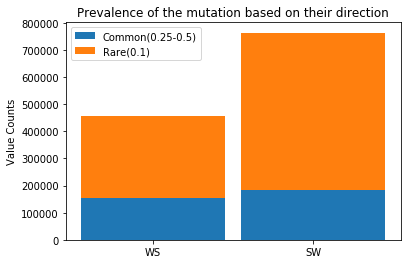

In [12]:
#Stacked bar graph
N = 2
Pdom_Intergenic_Common = (Pdom_Intergenic_WS_C, Pdom_Intergenic_SW_C)
Pdom_Intergenic_Rare = (Pdom_Intergenic_WS_R, Pdom_Intergenic_SW_R)
ind = np.arange(N) # the x locations for the groups
width = 0.9 # the width of the bars: can also be len(x) sequence

Pdom_Intergenic_p1 = plt.bar(ind, Pdom_Intergenic_Common, width)
Pdom_Intergenic_p2 = plt.bar(ind, Pdom_Intergenic_Rare, width, bottom=Pdom_Intergenic_Common)

plt.ylabel('Value Counts')
plt.title('Prevalence of the mutation based on their direction')
plt.xticks(ind, ('WS', 'SW'))
#plt.yticks(np.arange(0, 500001, 100000))
plt.legend((Pdom_Intergenic_p1[0], Pdom_Intergenic_p2[0]), ('Common(0.25-0.5)', 'Rare(0.1)'))

plt.show()

#### Chi-Square Test

In [10]:
test = np.array ([[Pdom_Intergenic_SW_R, Pdom_Intergenic_SW_C], [Pdom_Intergenic_WS_R, Pdom_Intergenic_WS_C]]) 
#array setup: SW-Rare,Common and WS-Rare,Common
chi2_contingency(test)
#output is in the order of X-value, p-value, dof, and the array of expected

(12151.923235207141, 0.0, 1, array([[552238.83544174, 211730.16455826],
        [329042.16455826, 126155.83544174]]))

#### Odd's Ratio

In [11]:
#defined as (a*d)/(b*c) = OR
#when C/R, OR for SW is:
print(Pdom_Intergenic_SW_C/Pdom_Intergenic_SW_R)

#OR for WS is:
print(Pdom_Intergenic_WS_C/Pdom_Intergenic_WS_R)

#OR overall, WS/SW is:
print((Pdom_Intergenic_WS_C/Pdom_Intergenic_WS_R)/(Pdom_Intergenic_SW_C/Pdom_Intergenic_SW_R))


0.3203955816803234
0.5038422148072286
1.5725629303775486
